In [1]:
from netCDF4 import Dataset
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import os
from glob import glob
import tqdm
import pandas as pd
import datetime
from metpy.calc import add_pressure_to_height
from metpy.calc import sigma_to_pressure
import warnings
import pickle
from metpy.units import units
import xarray as xr

In [2]:
df_sondes = pd.read_csv('../data/tables/SHEBA.csv')
df_sondes['dt0'] = pd.to_datetime(df_sondes['dt0'])


In [3]:
d = Dataset('../data/SHEBA/surf_obs.nc')

In [4]:
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    description: SHEBA tower data
    author: Stephan de Roode
    date: 22 June 2000
    dimensions(sizes): time(8112)
    variables(dimensions): float64 Jdd(time), float64 latitude(time), float64 longitude(time), float64 pressure(time), float64 ws2_5(time), float64 ws10(time), float64 wd2_5(time), float64 wd10(time), float64 T2_5(time), float64 T10(time), float64 q2_5(time), float64 q10(time), float64 rhi2_5(time), float64 rhi10(time), float64 T_sfc(time), float64 T_s_epp(time), float64 T_s_brns(time), float64 Tice(time), float64 LWd(time), float64 LWu(time), float64 SWd(time), float64 SWu(time), float64 SWucor(time), float64 tower_albedo(time), float64 line_albedo(time), float64 RR_org(time), float64 RR_ncr(time), float64 prep_SPO_corr(time), float64 ww(time), float64 ustar(time), float64 hs(time), float64 hl(time), float64 usb_2_5(time), float64 usb_10(time), float64 hsb_2_5(time), floa

In [5]:
dt0 = datetime.datetime(1997,1,1)

dates = [datetime.timedelta(days=int(np.floor(x))) + dt0 for x in d['Jdd'][:]]

hours = [datetime.timedelta(hours=(x%1)*24) for x in d['Jdd']]

dts = [date + hour for (date, hour) in zip(dates, hours)]

In [6]:
list_of_dicts = []

for i in tqdm.trange(d['Jdd'].shape[0]):
    
    dic = {'rlus':d['LWu'][i], 'rlds': d['LWd'][i], 
           'rlns': d['LWd'][i]-d['LWu'][i], 'T_surf': d['T_sfc'][i],
           'dt0':dts[i], 'lat': d['latitude'][i], 'lon': d['longitude'][i]}
    

    list_of_dicts.append(dic)
    
#     break


df = pd.DataFrame(list_of_dicts)
df = df[df['T_surf']>-200]
df = df[df['T_surf']<15]
df = df[df['rlds']<1000]
df = df[df['rlus']<1000]
    

100%|█████████████████████████████████████| 8112/8112 [00:04<00:00, 1763.42it/s]


In [7]:
df

,rlus,rlds,rlns,T_surf,dt0,lat,lon
50,213.0,216.7,3.7,-25.02,1997-11-01 01:59:57.120,75.71384,-144.27241
51,225.4,229.1,3.7,-21.49,1997-11-01 03:00:00.000,75.71275,-144.2618
52,233.6,236.4,2.8,-19.24,1997-11-01 04:00:02.880,75.71165,-144.24992
53,239.6,242.6,3.0,-17.62,1997-11-01 04:59:57.120,75.71046,-144.2383
54,241.5,244.1,2.6,-17.11,1997-11-01 06:00:00.000,75.70954,-144.2271
...,...,...,...,...,...,...,...
7935,298.0,295.5,-2.5,-3.94,1998-09-25 15:00:00.000,80.34802,-165.69415
7936,299.0,297.9,-1.1,-3.73,1998-09-25 16:00:02.880,80.34702,-165.70244
7937,298.3,294.4,-3.9,-3.88,1998-09-25 16:59:57.120,80.34632,-165.70745
7938,298.0,293.4,-4.6,-3.95,1998-09-25 18:00:00.000,80.34545,-165.70752


In [8]:
df.reset_index().to_csv('../data/tables/surface_obs_SHEBA.csv')

In [9]:
df_sondes

,Unnamed: 0,t0,dt0,month,inversion_strength,inversion_height,low_level_stability,rh_sub_850,surf_wind_velocity,wind_shear,dt_
0,0,-16.225000,1997-10-17 04:00:00,10,0.000000,-0.000000,-3.641667,0.576609,-999.0,1005.283251,1997-10-17 04:00:00
1,1,-17.854545,1997-10-18 20:00:00,10,3.654545,877.984821,1.354545,0.602644,-999.0,1001.289822,1997-10-18 20:00:00
2,2,-17.950000,1997-10-18 23:00:00,10,3.950000,619.460308,1.750000,0.600578,-999.0,1001.906664,1997-10-18 23:00:00
3,3,-13.225000,1997-10-20 04:00:00,10,0.625000,931.700101,-2.175000,0.444664,-999.0,1004.970000,1997-10-20 04:00:00
4,4,-8.026923,1997-10-20 23:00:00,10,0.000000,-0.000000,-6.073077,0.887422,-999.0,1010.645000,1997-10-20 23:00:00
...,...,...,...,...,...,...,...,...,...,...,...
361,811,-0.878788,1998-10-07 23:00:00,10,0.000000,-0.000000,-11.204545,0.731400,-999.0,1013.581602,1998-10-07 23:00:00
362,812,-18.361111,1998-10-08 23:00:00,10,10.961111,734.584421,8.794444,0.455908,-999.0,1004.046662,1998-10-08 23:00:00
363,813,0.228000,1998-10-09 11:00:00,10,0.000000,-0.000000,-9.248000,0.828475,-999.0,1015.959831,1998-10-09 11:00:00
364,814,9.071429,1998-10-09 23:00:00,10,0.000000,-0.000000,-15.338095,0.839477,-999.0,1015.753316,1998-10-09 23:00:00


In [18]:
### test sensitivity to time tolerance
tolerances = ["1min", "5min", "10min", "30min", "1h", "2h", "6h"]

for tolerance in tolerances:
    DF = pd.merge_asof(df_sondes, df, on='dt0', tolerance=pd.Timedelta(tolerance)).dropna()
    print("tolerance: ",tolerance)
    print("number of data points :", len(DF))
    print("")

tolerance:  1min
number of data points : 281

tolerance:  5min
number of data points : 281

tolerance:  10min
number of data points : 281

tolerance:  30min
number of data points : 281

tolerance:  1h
number of data points : 289

tolerance:  2h
number of data points : 290

tolerance:  6h
number of data points : 293



In [11]:
# now join the surface obs to the sondes
DF = pd.merge_asof(df_sondes, df, on='dt0', tolerance=pd.Timedelta("10min")).dropna()
DF.to_csv('../data/tables/SHEBA_merged.csv')

In [12]:
import seaborn as sns

<AxesSubplot: xlabel='low_level_stability', ylabel='rlns'>

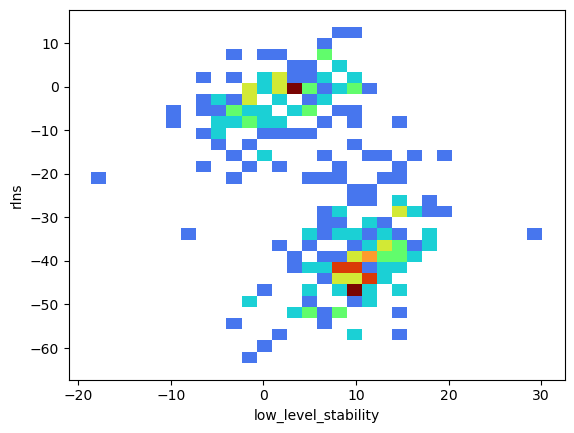

In [13]:
sns.histplot(data=DF.dropna(),
                x ='low_level_stability', y='rlns',
                #ax = axs.flatten()[i],
                cmap='turbo', bins=30)

/Users/ali/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(


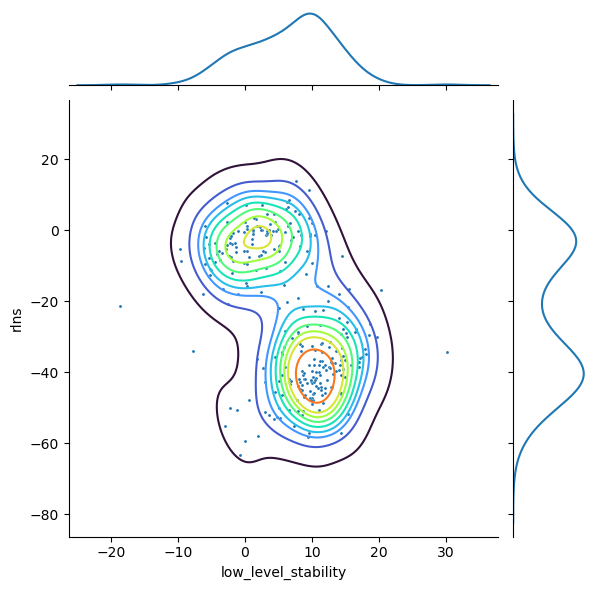

In [14]:


g = sns.jointplot(data=DF.dropna(),
                x ='low_level_stability', y='rlns', kind='kde',
                #ax = axs.flatten()[i],
                cmap='turbo', bins=30)

g.plot_joint(sns.scatterplot, s=5)
                #ax = axs.flatten()[i],
                #cmap='turbo', bins=30)

/Users/ali/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(


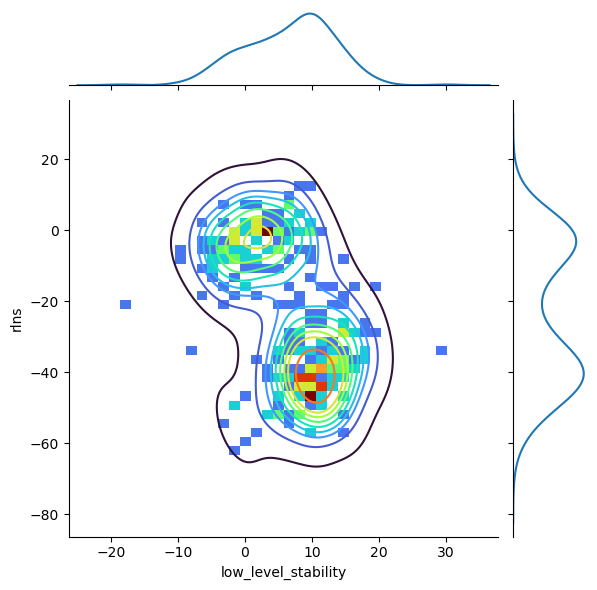

In [15]:

g = sns.jointplot(data=DF.dropna(),
                x ='low_level_stability', y='rlns', kind='kde',
                #ax = axs.flatten()[i],
                cmap='turbo', bins=30)

g.plot_joint(sns.histplot, 
                #ax = axs.flatten()[i],
                cmap='turbo', bins=30)

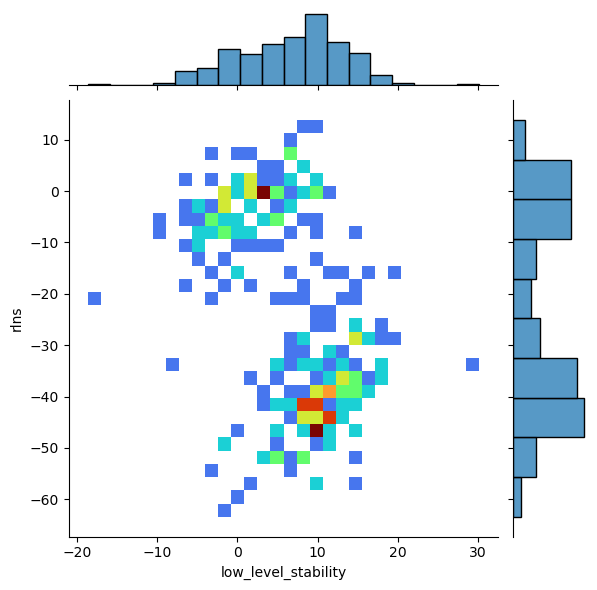

In [16]:

g = sns.jointplot(data=DF.dropna(),
                x ='low_level_stability', y='rlns', kind='hist',
                #ax = axs.flatten()[i],
                cmap='turbo', bins=30)

plt.savefig('../figures/SHEBA_lls_rlns.png', dpi=300)